<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/branch_1/TVAE_Test_and_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 7.8MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd
from random import randint
import pickle

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [4]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [5]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [6]:
data.sample(10)

,line,len,book,genre,category,Sentimiento
86759,de nada le sirvió la luz opaca de sus vicios,44,_medianamente_dulces_-_Alma_Phillip,poesía,Book,NEG
104742,enterrar a @name era diferente para ella,42,Deseos_concedidos_-_Danielle_Steel,Novelas,Book,NEG
199552,"sospechaba que @name era incapaz de franquearse con nadie , de amar o entregarse por completo",97,Aguila_solitaria_-_Danielle_Steel,Novelas,Book,NEG
100413,se subió al pequeño descapotable rojo de dos plazas y rezó para que el motor arrancara,88,a_extrana_propuesta_-_Allison_Leigh,Novelas,Book,NEU
50261,los hombres superiores huyen asustados,40,lo_Zaratustra_-_Friedrich_Nietzsche,filosofia,Book,NEG
65969,no hay sitio en este mundo para soltar mi furia sin acabar con él,67,_cosas_que_escribi_-_Ainhoa_Escarti,poesía,Book,NEG
86709,a la salud emocional de aquellos que abrazara filialmente,59,_medianamente_dulces_-_Alma_Phillip,poesía,Book,NEU
93602,la enfermera salió silenciosa de la sala para comunicar la mejoría al doctor,78,do_late_un_corazon_-_Danielle_Steel,Novelas,Book,NEU
216088,@name vez debería haber aceptado la propuesta de rourke de ir a visitar niza,78,trato_de_matrimonio_-_Allison_Leigh,Novelas,Book,NEG
176516,y entonces él situó el rostro a su misma altura,49,suntos_del_corazon_-_Danielle_Steel,Novelas,Book,NEU


In [7]:
data.shape

(316618, 6)

In [90]:
## tokenizador de subwords
path_to_tokenizer = os.path.join(folder, 'tokenizer.pkl')
with open(path_to_tokenizer, 'rb') as tk_pkl:
        tokenizer = pickle.load(tk_pkl)

### Preprocesamiento

In [9]:
# Usamos train_test_split() para filtrar el volumen de lineas que le vamos a pasar al entrenamiento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['line', 'len', 'book', 'Sentimiento']], data['genre'], test_size=0.03, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (307119, 4) X_test:  (9499, 4) y_train:  (307119,) y_test:  (9499,)


In [10]:
data_train = pd.concat([X_train, y_train],axis=1)
data_test = pd.concat([X_test, y_test],axis=1)

In [11]:
VOCAB_SIZE = tokenizer.vocab_size
MAX_LENGTH = 32

In [12]:
# Funcion para utilizar luego en la reconstrucción
def tokenize_and_filter(inputs):
  tokenized_inputs = []
  
  for sentence1 in inputs:
    # tokenizamos + tokens especiales
    sentence1 = tokenizer.encode(sentence1)
    # filtramos
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [13]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter_df(inputs):
  tokenized_inputs = {}
  count_dict = 0
  for index, line in inputs.iterrows():
    sentence = line['line']
    # tokenizamos + tokens especiales
    sentence = tokenizer.encode(sentence)
    # filtramos
    if len(sentence) <= MAX_LENGTH:
      # tokenized_inputs.append(sentence)
      tokenized_inputs[count_dict] = {"line": line['line'], 'secuence': sentence, "len": len(sentence), "genre": line['genre'], "sent": line['Sentimiento']}
      count_dict += 1

  data_filtered = pd.DataFrame.from_dict(tokenized_inputs, "index")
  
  return data_filtered

data_tokens = tokenize_and_filter_df(data_train)
data_tokens_test = tokenize_and_filter_df(data_test)

In [14]:
display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

,line,secuence,len,genre,sent
111084,@name siquiera tenía tiempo de leer el periódico,"[7997, 9, 278, 56, 110, 2, 1671, 8, 1866]",9,Novelas,NEG
129825,"@name no sé si esa música , esos vasos de whisky","[7997, 9, 11, 188, 38, 134, 4462, 1, 478, 6022, 20, 2, 4444]",13,poesía,NEG
272608,a la hora de comer volvió a la casa para ver cómo estaba,"[5, 4, 347, 2, 1449, 207, 5, 4, 121, 29, 123, 136, 1033]",13,Novelas,NEU


,line,secuence,len,genre,sent
5010,tus esporas se fueron introduciendo y mutaron mi para dejarme toda tu esencia en cada célula,"[298, 2811, 1102, 20, 10, 525, 5860, 2954, 37, 6, 4791, 1139, 58, 29, 1002, 28, 175, 81, 5486, 5...",25,poesía,NEG
5974,fíjese que los chicos que ríen mucho acaban llorando,"[2464, 2141, 45, 3, 15, 1364, 3, 2888, 7, 82, 1678, 46, 5734]",13,cortazar,NEG
6957,"mientras @name recogía su pequeña maleta de la cinta transportadora , lo observó y vio que est...","[1108, 12, 9, 2239, 5369, 18, 896, 2535, 7965, 2, 4, 2975, 260, 3808, 5060, 1752, 1, 14, 2033, 6...",25,Novelas,NEU


In [15]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')

data_lines_test = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens_test.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')


data_tokens['secuence'] = data_lines.tolist()
data_tokens_test['secuence'] = data_lines_test.tolist()

display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

,line,secuence,len,genre,sent
48016,"te veo , sentada en el pupitre que me describes","[36, 500, 8044, 1, 1644, 7, 8, 1111, 2387, 1174, 3, 28, 5492, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14,cortazar,NEU
220347,significaba que se quedaría completamente sola por primera vez en toda su vida,"[2905, 3, 10, 5464, 7965, 1393, 628, 19, 270, 69, 7, 175, 18, 219, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14,Novelas,NEG
158560,"@name sale y baja lentamente la escalera , llega a la calle , mira y se pregunta dónde puede...","[7997, 9, 4411, 6, 3906, 1219, 4, 4712, 1, 2989, 5, 4, 1038, 1, 3190, 6, 10, 1343, 520, 169, 176...",23,cortazar,NEG


,line,secuence,len,genre,sent
257,"la riqueza de ciertas instituciones monásticas irrita , más todavía cuando no se aprecia esta ...","[4, 473, 5611, 7965, 2, 5886, 5697, 402, 794, 1129, 2205, 20, 5482, 1, 33, 225, 41, 11, 10, 3228...",31,filosofia,NEG
2094,buscó el número en su agenda y lo marcó,"[7542, 8, 1598, 7, 18, 6232, 72, 6, 14, 4620, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",11,Novelas,NEU
2022,"pues bien , hay que pensar que @numbertal ocurre también en la tierra , comparando lo grande...","[340, 202, 1, 161, 3, 299, 63, 12, 131, 245, 1513, 85, 7, 4, 1066, 1, 4268, 70, 14, 1956, 5, 14,...",23,filosofia,NEU


In [16]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 302936


### Elementos básicos

In [17]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [19]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [20]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [21]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [22]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [23]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, latent_space, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([MAX_LENGTH * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(MAX_LENGTH * 10)(outputs)

  outputs = tf.keras.layers.Dense(latent_space)(outputs)
  

  mu = Dense(latent_space, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente


  # Generamos el logaritmo de la varianza
  logvar = Dense(latent_space, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

### Decoder

In [25]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [26]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout ,latent_space, name='decoder'):

  decoder_input = tf.keras.Input(shape=(latent_space), name='decoder_input')

  output = tf.keras.layers.Dense(MAX_LENGTH * 10)(decoder_input)

  
  output = Dense(MAX_LENGTH * d_model, name='linear_proyection')(output)

  output = tf.keras.layers.Reshape([MAX_LENGTH, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs])

  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)
  outputs = tf.keras.layers.LSTM(units=256, return_sequences=True, name='LSTM')(outputs)
  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)


  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

### Modelo VAE

In [27]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False

class VAEModel(Model):
    def __init__(self, encoder, decoder, a, b, vocab_size, num_layers, units, d_model, num_heads, dropout, latent_space, mask=None,  **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.a = a
        self.b = b

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        data = data[0]

        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las oraciones al espacio latente y obtenemos los parámetros de la distribución
            
            
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la oración a partir de z

            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            # Escalamos la pérdida con el r_loss_factor
           # reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            factor = self.a * beta + self.b
            total_loss = reconstruction_loss + kl_loss * factor

        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "kl_weight": factor,
        }

    def reconstruct(self, q_sample, silent_reconstruct=False, silent_orig=True):
      _,_,result = model.encoder(q_sample.reshape(1,MAX_LENGTH,1))
      #decoded from sample
      print('Reconstr: ',self.decode_sample(result, silent_reconstruct))

      # original  
      print('Original: ',tokenizer.decode([i for i in q_sample if i < tokenizer.vocab_size]))
      if (silent_orig == False):
        print(q_sample)

    def decode_sample(self, z_sampled, silent_reconstruct=False):
      result = self.decoder(z_sampled)
      with suppress(Exception):
        prediction = np.argmax(result, axis=2)

        pred = prediction[0]
        pred_to_decode = [i for i in pred if i < tokenizer.vocab_size]
        if (silent_reconstruct == False):
          print(pred_to_decode)
        return tokenizer.decode(pred_to_decode)


    def reconstruct_sentence(self, sentence, silent_reconstruct=False, silent_orig=True):
      sentence = [sentence]
      sentence = tokenize_and_filter(sentence)
      sentence = sentence.reshape(MAX_LENGTH)
      return self.reconstruct(sentence, silent_reconstruct, silent_orig)

    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")

        return self.decoder(z)

In [28]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.0000001
B = 0.00001

# Instanciamos el modelo
model = VAEModel(encoder, decoder, 
    a=A,
    b=B,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


# Cargamos el modelo

In [29]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5')

# Analizando el espacio latente

In [30]:
def generate_from_normal(n_sentences=3):
  errores = 0
  for i in range(n_sentences):
    z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
    prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
    print(i, ' gen_norm:', prediction)

In [31]:
generate_from_normal()

0  gen_norm: pero aun advirtieron en kate casarse y  ,  y @number bueno  ,  al instante  ?
1  gen_norm: y además me dicen de cabeza del juego que lo san y @number sargento
2  gen_norm: None


In [32]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

[28, 3078, 91, 314, 97, 550, 31, 538, 1, 19, 13, 4027, 3668, 7965, 2, 1217, 3273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  me enteré ante ese nombre del después  ,  por un simple relato de borges
Original:  me enteré de ese nombre mucho después  ,  por un hermoso relato de borges


In [33]:
model.reconstruct_sentence("el devenir de los momentos", silent_reconstruct=True)
model.reconstruct_sentence("las historias que nos contaron", silent_reconstruct=True)
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio", silent_reconstruct=True)
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo", silent_reconstruct=True) 
model.reconstruct_sentence("un hombre observaba desde el monte", silent_reconstruct=True) 

Reconstr:  el profesor venir de ese libro
Original:  el devenir de los momentos
Reconstr:  las razones que nos llegaron
Original:  las historias que nos contaron
Reconstr:  tu mirada aparentasa que acordó de su odio
Original:  tu mirada milagrosa me salvó de su odio
Reconstr:  arriba como un rayo de luz que haljo al mundo
Original:  cayó como un rayo de luz que cegó al mundo
Reconstr:  mantenía poco observaba desde el monte
Original:  un hombre observaba desde el monte


In [34]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
def linear_interpolate(sample1, sample2, cant_sentences = 5 ):
  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))
  _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  for i in range(cant_sentences):
    result_int = result1 - vector * i
    print('step', str(i + 1) + ':', model.decode_sample(result_int, silent_reconstruct=True))

  print('')
  print('hasta:', tokenizer.decode(q_sample2))


In [54]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

linear_interpolate(q_sample1, q_sample2,6)


desde: al parecer su marido la culpa a ella  ,  creo que sencillamente porque no sabe a quién culpar 

step 1: al parecer su principio la culpa a ella  ,  creo que sencillamente porque no sabe a quién culpar
step 2: la gente tendrá absolutamente muy muchísimo sobre así  ,  es que entiende mientras que alguien de me saberestá
step 3: sería hecho al opinión el hombre o entonces  ,  por qué contestara con ella siguió parece que unos llamate fue élcruel
step 4: en curioso mío sueño estuvieron verla de marcharse  ,  así te creer con papá por hizo   ¡ no la admitirme ni todavía efisulara
step 5: por el una veinte años recibió la nuevo  ,  como lo vio así volvió saber ellos hombres y con razón y él yo había muy ciudada
step 6: como tuvieron cada niña semana de más semana y qué era era ange gustaba algo o suerte  ,  ya después  ,  así que creyhacía su punto

hasta: le dio un abrazo fuerte a su tía y le dijo que se alegraba mucho de verla  ,  y entonces @name se la presentó a blue


# Analisis Visual del espacio latente

In [36]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [37]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("deberas dejar cerrada aquella puerta")

linear_interpolate(q_sample1, q_sample2,5)

desde: un hombre observaba desde el monte 

step 1: mantenía poco observaba desde el monte
step 2: las las buenas estaban haciendo roca
step 3: aquellos las echaba volvieron muy quieto
step 4: daban todas aquellas las hicieron acercarpronto
step 5: salvarendo aquellas fotos aquella los lentamente

hasta: deberas dejar cerrada aquella puerta


In [38]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("al despertarse una mañana, después de un sueño intranquilo")
q_sample2 = encode_sentence("se encontró en su cama transformado en un monstruoso insecto")

linear_interpolate(q_sample1, q_sample2,10)

desde: al despertarse una mañana, después de un sueño intranquilo 

step 1: al despertarse una primera posta después de un sueño intranquilo
step 2: aquella ademán que del orden cultura una de las cierta imposificaas
step 3: la impresión que tenías orden rocaal llamó la menor estrella impotensión ble
step 4: hubo fría ya el elegante figuras reconoció más detotalmente habiariadoedad
step 5: a primeras también el arte presenteía bajo su exigente impljordamente alegría
step 6: habían dejado como el señor mentaló más tan gracioso inmeerado vida
step 7: None
step 8: para espera por ello mesa datos de el correspondeoso agresiva
step 9: también las había tan pequeña presentaba parecía una capacidad inserta
step 10: le entraron con su pequeña acusado a una comprensiso injustlemente

hasta: se encontró en su cama transformado en un monstruoso insecto


In [52]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("tierra que todo crece a su paso")
q_sample2 = encode_sentence("la tierra que perdura la especie")

linear_interpolate(q_sample1, q_sample2,5)

desde: tierra que todo crece a su paso 

step 1: palabras que todo crece a su paso
step 2: llena así es menudmente sobre una fiesta
step 3: gracias a lo preparados tiene las nombres
step 4: libre atrás nos razondo de libertad dioses
step 5: mi madre ya acudieran la predoca

hasta: la tierra que perdura la especie


In [39]:
z_mean, z_signa, z_sample = model.encoder.predict(data_tokens_test.secuence.tolist())

In [59]:
# Elige una métrica

metric = z_sample

In [60]:
from sklearn.decomposition import PCA

pca_X = PCA(n_components=10)
pca_X.fit(metric)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [61]:
df_pca = pd.DataFrame(pca_X.fit_transform(metric))

In [57]:
import plotly.express as px

In [58]:
data_plot = data_tokens_test

x_coord = np.array(df_pca)[:,0].astype(float)
y_coord = np.array(df_pca)[:,1].astype(float)
z_coord = np.array(df_pca)[:,2].astype(float)    

marks_size = [2 for i in range(len(x_coord))]

fig = px.scatter_3d(x = x_coord, y = y_coord, z = z_coord, 
              color = data_plot["genre"], opacity = 0.6, size = data_plot['len'],hover_name=data_tokens_test['line'],)

fig.show()

# Similaridad entre las frases


In [87]:
z_mean, z_signa, z_sample = model.encoder.predict(data_tokens.secuence.tolist())

In [73]:
# Funcion para generar un un DataFrame de similitud coseno dada la metrica elegida
from sklearn.metrics.pairwise import cosine_similarity
def get_similarity(metric):
  lines_similarity = cosine_similarity(metric)
  return pd.DataFrame(lines_similarity,index=data_tokens_test['line'], columns=data_tokens_test['line'])

samples_similarity_df = get_similarity(z_sample)
samples_similarity_df = get_similarity(z_mean)

In [81]:
# Permite buscar una linea y sus resultados mas cercanos por texto o por índice
def find_line(find_line, df, retunr_lines=10):
  if (type(find_line) == str):
    get_line = lines_similarity_df[lines_similarity_df.index.str.contains(find_line)].index[0]#.tema.iloc[0]
    return lines_similarity_df.loc[get_line,:].sort_values(  ascending=False ).head(10)
  else:
    return lines_similarity_df.iloc[find_line,:].sort_values(  ascending=False ).head(10)  

In [86]:
find_line('el teléfono móvil la despertó a las tres de la madrugada', samples_similarity_df)

line
en consecuencia  ,  regresó a nueva @name                                                                                            1.000000
le dio la espalda para abrir la puerta y el hombre sonrió                                                                            0.618397
si tú puedes  ,  yo lo haré también                                                                                                  0.587803
le quedaban quince minutos de espera                                                                                                 0.586369
en vanguardia iban dos troncos unidos                                                                                                0.574985
por estos sotos  ,  antes que nosotros                                                                                               0.572268
y esa dedicación no tardó en distanciarla de @name                                                                                   0.560040
e

In [46]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  ax_y = int(LATENT_SPACE / 4)
  fig, axes = plt.subplots(4, ax_y, figsize=(20,12))
  fig.subplots_adjust(hspace=0.4)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(ax_y): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z])
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



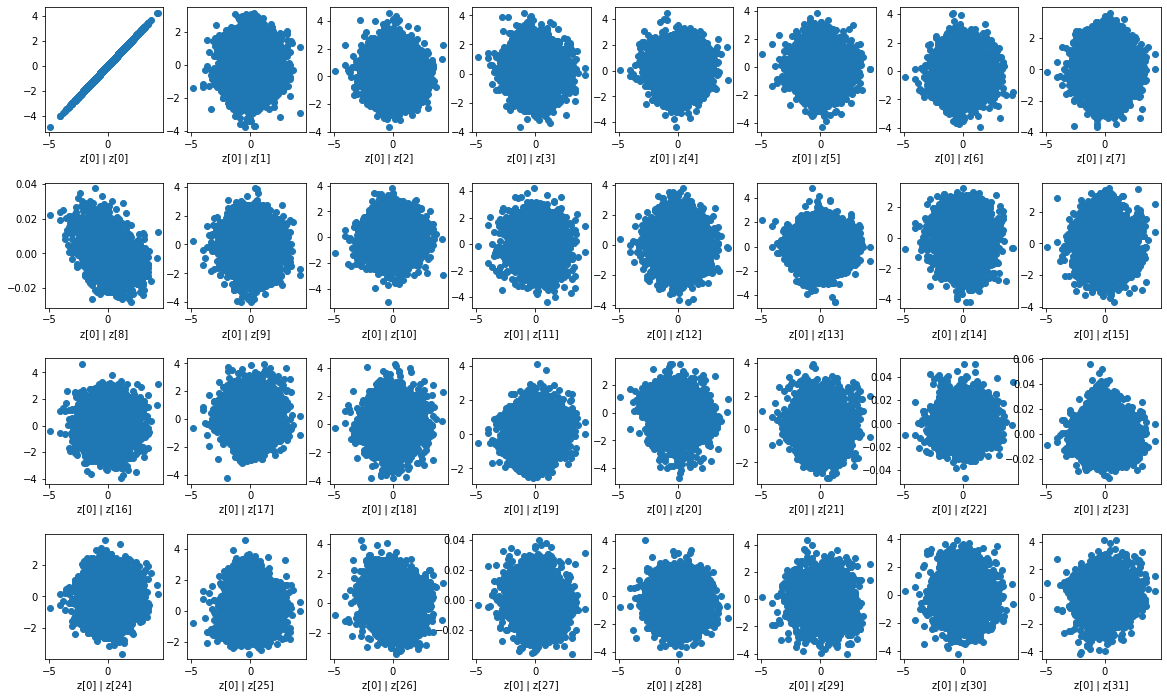

In [47]:
plot_label_clusters(model, z_mean, data_tokens['genre'], 0)

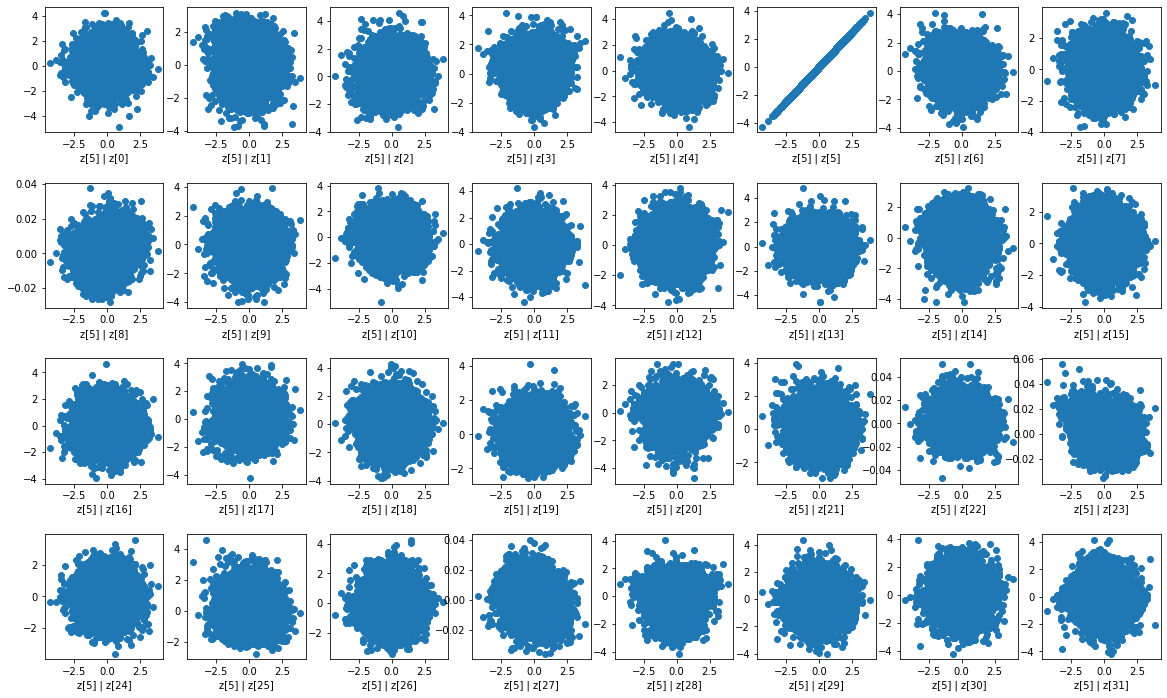

In [48]:
plot_label_clusters(model, z_mean, None, 5)

Visualización de como cambia el factor de loss en kl para los parametros y cantidad de epochs